Problem statement

Identify whether an image is a horse or a human

Import libraries

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns

Load files

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/horses-or-humans-dataset/horse-or-human/validation/humans/valhuman03-22.png
/kaggle/input/horses-or-humans-dataset/horse-or-human/validation/humans/valhuman02-05.png
/kaggle/input/horses-or-humans-dataset/horse-or-human/validation/humans/valhuman01-24.png
/kaggle/input/horses-or-humans-dataset/horse-or-human/validation/humans/valhuman05-26.png
/kaggle/input/horses-or-humans-dataset/horse-or-human/validation/humans/valhuman04-00.png
/kaggle/input/horses-or-humans-dataset/horse-or-human/validation/humans/valhuman02-00.png
/kaggle/input/horses-or-humans-dataset/horse-or-human/validation/humans/valhuman01-21.png
/kaggle/input/horses-or-humans-dataset/horse-or-human/validation/humans/valhuman04-18.png
/kaggle/input/horses-or-humans-dataset/horse-or-human/validation/humans/valhuman05-01.png
/kaggle/input/horses-or-humans-dataset/horse-or-human/validation/humans/valhuman01-12.png
/kaggle/input/horses-or-humans-dataset/horse-or-human/validation/humans/valhuman01-03.png
/kaggle/in

In [3]:
import pathlib

data_dir = "/kaggle/input/horses-or-humans-dataset/horse-or-human/" # Datasets path
data_dir = pathlib.Path(data_dir)
data_dir


PosixPath('/kaggle/input/horses-or-humans-dataset/horse-or-human')

In [4]:
train_horses = list(data_dir.glob('train/horses/*'))
train_humans = list(data_dir.glob('train/humans/*'))

val_horses = list(data_dir.glob('validation/horses/*'))
val_humans = list(data_dir.glob('validation/humans/*'))


print("Length of train_horses: ", len(train_horses))
print("Length of train_humans: ", len(train_humans))

print("Length of val_horses: ", len(val_horses))
print("Length of val_humans: ", len(val_humans))

Length of train_horses:  500
Length of train_humans:  527
Length of val_horses:  128
Length of val_humans:  128


476
524


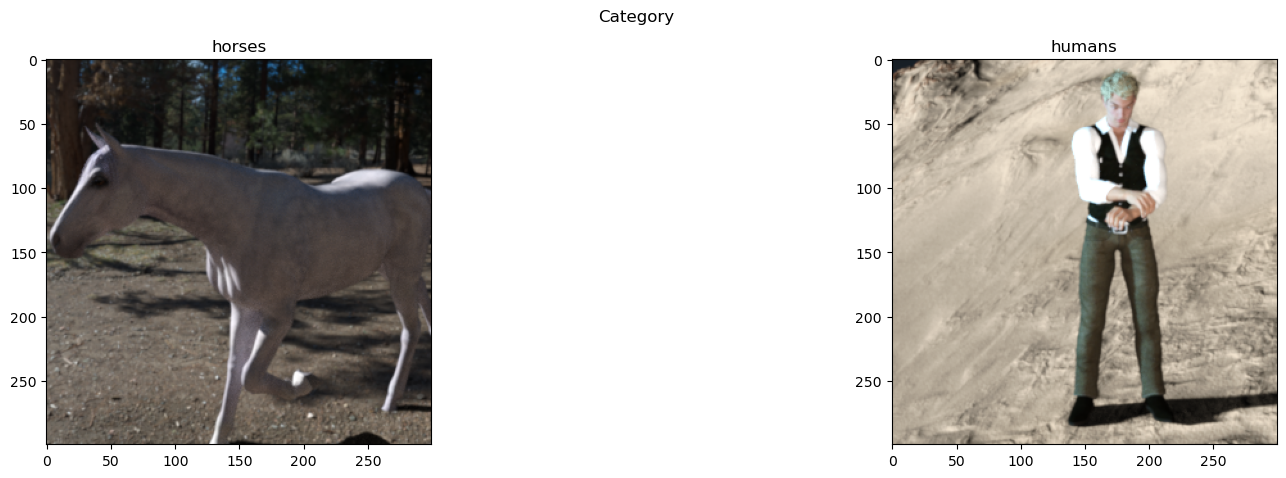

In [5]:
import matplotlib.image as img
import PIL.Image as Image

fig, ax = plt.subplots(ncols= 2, nrows = 1, figsize=(20,5))
fig.suptitle('Category')

rand_horses = np.random.randint(-1,len(train_horses))
print(rand_horses)

rand_humans = np.random.randint(-1, len(train_humans))
print(rand_humans)

horses_image = img.imread(train_horses[rand_horses])
humans_image = img.imread(train_humans[rand_humans])

ax[0].set_title('horses')
ax[1].set_title('humans')

ax[0].imshow(horses_image)
ax[1].imshow(humans_image)


In [6]:
# contains the images path

df_images = {
    'train_horses' : train_horses,
    'train_humans' : train_humans,
    'val_horses': val_horses,
    'val_humans': val_humans
}

# contains numerical labels for the categories
df_labels = {
    'train_horses' : 0,
    'train_humans' : 1,
    'val_horses': 0,
    'val_humans': 1
}

In [7]:
import cv2

img = cv2.imread(str(df_images['train_horses'][rand_horses])) # Converting it into numerical arrays
img.shape

(300, 300, 3)

Define X and y

In [8]:
X, y = [], [] # X = images, y = labels
for label, images in df_images.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, (224, 224)) # Resizing the images to be able to pass on MobileNetv2 model
        X.append(resized_img) 
        y.append(df_labels[label])
print(len(X), len(y))


1283 1283


Normalise images

In [9]:
X = np.array(X)
y = np.array(y)

Split into training and validation sets

In [10]:

from sklearn.model_selection import train_test_split

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, train_size = 0.8, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, random_state=42)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1026, 224, 224, 3),
 (65, 224, 224, 3),
 (192, 224, 224, 3),
 (1026,),
 (65,),
 (192,))

Define model

In [11]:
import tensorflow as tf 
from tensorflow import keras 
import tensorflow_hub as hub
from keras.callbacks import ModelCheckpoint, EarlyStopping
print(tf.__version__)

2.11.0


In [12]:
normalizer = tf.keras.layers.Rescaling(scale=1/255)

In [13]:
mobile_net = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4' # MobileNetv4 link
mobile_net = hub.KerasLayer(
        mobile_net, input_shape=(224,224, 3), trainable=False) # Removing the last layer


In [14]:

num_label = len(np.unique(y)) # number of labels

model = keras.Sequential([
    keras.Input(shape=(224,224,3)),
    normalizer,
    mobile_net,
    keras.layers.Dropout(0.2),
    keras.layers.Dense(num_label),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [15]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=25, verbose=1)
mc = ModelCheckpoint ('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping, mc])

Epoch 1/100
33/33 [==============================] - 11s 63ms/step - loss: 0.1793 - acc: 0.9405 - val_loss: 0.0130 - val_acc: 1.0000
Epoch 2/100
33/33 [==============================] - 1s 35ms/step - loss: 0.0186 - acc: 0.9971 - val_loss: 0.0058 - val_acc: 1.0000
Epoch 3/100
33/33 [==============================] - 1s 35ms/step - loss: 0.0124 - acc: 0.9981 - val_loss: 0.0050 - val_acc: 1.0000
Epoch 4/100
33/33 [==============================] - 1s 34ms/step - loss: 0.0074 - acc: 0.9990 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 5/100
33/33 [==============================] - 1s 35ms/step - loss: 0.0059 - acc: 0.9990 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 6/100
33/33 [==============================] - 1s 35ms/step - loss: 0.0056 - acc: 0.9990 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 7/100
33/33 [==============================] - 2s 46ms/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 8/100
33/33 [==============================] - 1s 34ms/step - loss: 0

Make predictions

In [17]:
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_pred_bool

3/3 [==============================] - 1s 26ms/step


array([1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0])

In [18]:
from sklearn.metrics import accuracy_score

total_right = accuracy_score(y_test, y_pred_bool, normalize=False)
print(total_right)
accuracy = (total_right / len(y_test))
print(accuracy)

191
0.9947916666666666


In [19]:
model.evaluate(X_test,y_test)

6/6 [==============================] - 0s 24ms/step - loss: 0.0233 - acc: 0.9948


[0.023293867707252502, 0.9947916865348816]

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_bool))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        87
           1       0.99      1.00      1.00       105

    accuracy                           0.99       192
   macro avg       1.00      0.99      0.99       192
weighted avg       0.99      0.99      0.99       192



In [21]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred_bool)

array([[ 86,   1],
       [  0, 105]])

In [22]:
df = pd.DataFrame({'actual': y_test, 'predicted': y_pred_bool})
df

,actual,predicted
0,1,1
1,1,1
2,1,1
3,1,1
4,0,0
...,...,...
187,0,0
188,0,0
189,0,0
190,1,1


In [23]:
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px

init_notebook_mode(connected=True)

acc = pd.DataFrame({'train': history.history['acc'], 'val': history.history['val_acc']})

fig = px.line(acc, x=acc.index, y=acc.columns[0::], title='Training and Evaluation Accuracy every Epoch', markers=True)
fig.show()


In [24]:
loss = pd.DataFrame({'train': history.history['loss'], 'val': history.history['val_loss']})

fig = px.line(loss, x=loss.index, y=loss.columns[0::], title='Training and Evaluation Loss every Epoch', markers=True)
fig.show()